## Today's announcements
* TA office hour
* ipython in terminal in physma VM

# Numerical derivatives and differential equations


## Numerical derivatives

In this section we will learn how we can calculate a derivative numerically. The fundamental idea involves replacing differentials with differences. An important aspect is to think about the types of errors that emerge when doing that, especially we have to introduce the important concepts of rounding error and truncation errors.

**Literature:** Numerical Recipies, Ch. 5.7

### Difference equations

In [8]:
from IPython.display import Image
#Image(filename='../images/numerical_analysis_derivative.jpg') 

The derivative $\frac{df}{dx}$ of a function $y=f(x)$ can be approximated by the difference equation 
$$ f'(x) \approx \frac{f(x+h) -f(x)}{h}.$$

Say we have the following function $f(x) = x^2$:

In [2]:
def func1(x):
    return x**2

We can plot this function:

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


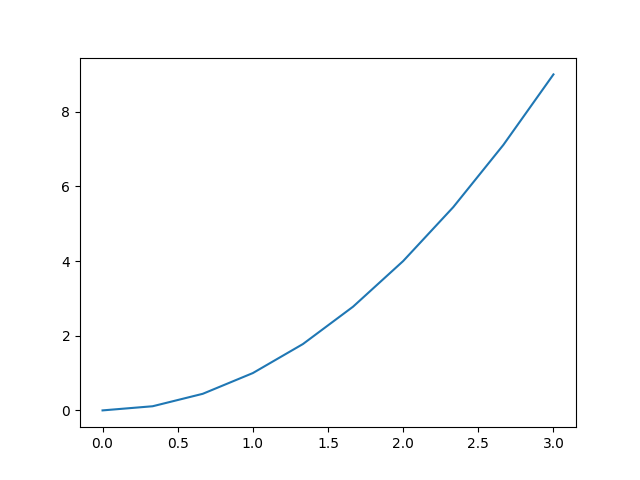

In [3]:
%pylab nbagg
x = linspace(0,3,10)
figure(1)
plot(x,func1(x))

Now, we create a function for the derivative:

In [4]:
def deriv1(f,x,h):
    dfdx = (f(x+h) - f(x)) / h
    return dfdx

You should try the deriv function call below with different values of h. 

In [5]:
deriv1(func1,1,1.e-14) - 2.0

-0.0015985556747182272

Note that the answer is not exactly `2.00000000` as we know the answer to be from the analytical approach. But smaller values of `h` give a better answer? _Right?_ well, let's see .... let's analyse the error in a bit more detail:

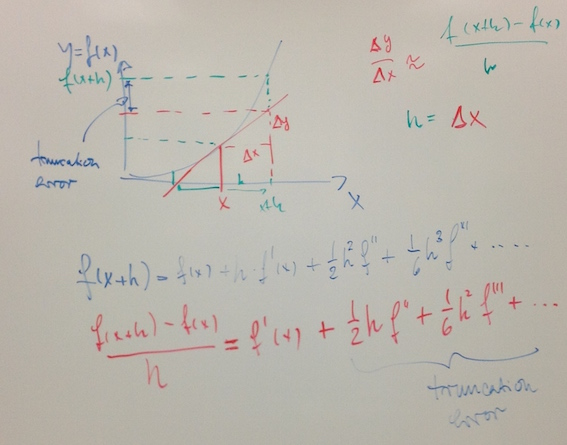

In [9]:
Image(filename='../images/differentiate.jpg') 

### Errors
There are two basic sources of error! They have to do with accuracy and with precision.

**Accuracy:** How well does the discretized equation represent the original mathematical equation?
This is the truncation error. 

**Precision:** How well is the solution satisfying the discretized equation? This is limited by the roundoff error.

#### Convergence test
In order to determine the accuracy of our solution scheme we study the behaviour of a particular solution scheme under grid (time and/or space) refinement. In our case this means we do a series of runs with decreasing `h`.

We use a convenient technique for _vectorizing_ a function which allows to evaluate an arbitrary function for a _parameter vector_. This way of doing it will not help performance. See an example below of how to do true multi-tasking.

In [10]:
# in order to vectorize wrap the function to isolate the 
# variable over which we should loop turn a scalar function 
# into a vectorized function
def hdev(h):
    return deriv1(func1,1.,h)
vhdev = vectorize(hdev)
h_pow = range(0,-16,-1)

<IPython.core.display.Javascript object>


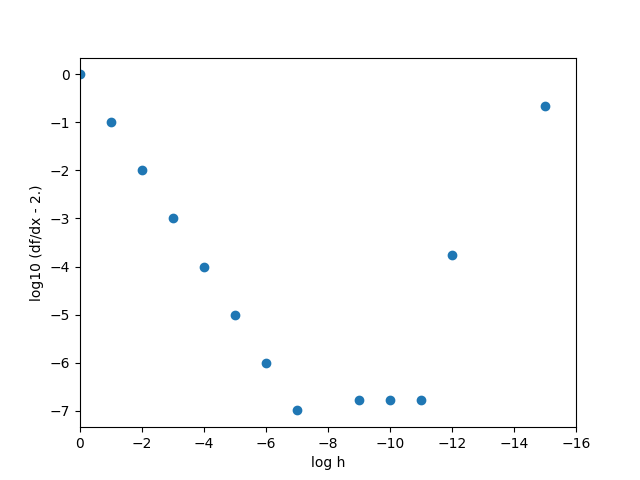

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()


((0, -16),
 <matplotlib.text.Text at 0x7f4b7d5db550>)

In [12]:
h = 10**array(h_pow, dtype=float)
figure(2)
plot(h_pow, log10(vhdev(h)-2.0),'o')
xlim(0,-16), ylabel('log10 (df/dx - 2.)'), xlabel('log h')

You can reduce the truncation error by taking a smaller interval `h`. However, as you try minimizing the truncation error you will see that there is a limit. At too small `h` the `derive1` function will try to perform the difference `(f(x+h) - f(x))` with too few or no significant digits and the roundoff error will become larger, and eventually dominate the result. 



### Multi-processing

We saw an example for a case where a particular task needs to be done over and over again with different input parameters. A previous example of this type was the Monte Carlo method. Such problems are called _embarissingly parallel_, essentially because it takes no or very little effort to parallelize them. The following introduces an actual multiprocessing approach that will use multiple of your cpu cores. The work is too small to notice any difference in performance though. You may want to experiment with a task that has more work, and in an environment that has indeed multiple cores (such as you laptop or the physma virtual machine). 

In [13]:
from multiprocessing import Pool

[ 3.          2.1         2.01        2.001       2.0001      2.00001
  2.000001    2.0000001   1.99999999  2.00000017  2.00000017  2.00000017
  2.0001778   1.99840144  1.99840144  2.22044605]


<IPython.core.display.Javascript object>


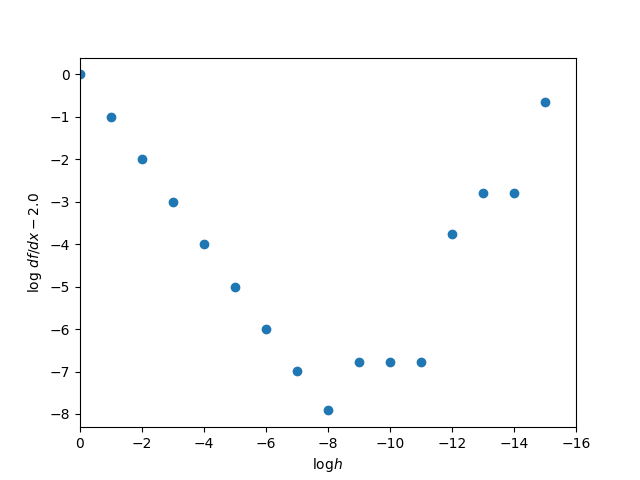

((0, -16),
 <matplotlib.text.Text at 0x7f4b952c2358>)

In [14]:
p = Pool(3)
h_error = array(p.map(hdev,h))
print(h_error)
figure(3)
plot(h_pow,log10(abs(h_error-2.)),'o')
xlim(0,-16), ylabel('$ \log$ $df/dx - 2.0 $'),xlabel('$\log h$')

## Ordinary differential equations
Differential equations are often hard to solve on paper but in many cases become trivial on a computer. We will start with the **Skydiver problem**.

## Falling body with drag

A falling body - say a sky diver - will increase speed when she jumps off the plane because she is accelerated by the earth's gravity. However, the speed will not increase forever. In addition to the gravitational force the sky diver will feel the drag force due to air resistance.

What is the terminal velocity of the sky diver? This will depend on the balance of two forces: the gravitational force and the drag force that describes the air resistance


### Equation of motion
The equation of motion for the velocity is $v = a t +v_0$ where $a$ is the acceration and $v_0$ the initial velocity. But this is of course just a special case of the more general case
$$\frac{d\vec{p}}{dt} = \sum \vec{F}_i .$$
where $\vec{p}$ is the momentum and $\vec{F}_i$ is one of several forces that may act, like gravitational force and friction.

### Forces
We will consider a 1D motion in the vertical direction, and therefore consider the scalar equations.

#### Gravity

$$F = - m g$$
where $m$ is the mass of the body and $g$ is the magnitude of the gravitational acceleration.

#### Air drag

In order to obtain an idea of what a formula for the air drag could be we use dimensional analysis. This method is based on the principle that every physics equation must be dimensionally homogeneous, i.e. the units on each side of the equation must be the same. We are looking for a force, which has the unit 
$$ [F] = \frac{ML}{T^2}$$
where $M$, $L$ and $T$ stand for the mass, length and time unit. We then consider what the drag force could possibly depend on. This consideration is where the physics happens. We expect that the drag force will somehow depend on the following:

- density $\rho$ of medium through which object is moving, in this case air
- velocity $v$
- cross section of object $A$

We are looking for an expression of the type
$$F = C_D \rho^a v^b A^c$$ 
where $C_D$ is a dimensionless coefficient and $a$, $b$ and $c$ are derived from the condition that unit of $F$ has to come out correctly. You can easily confirm that this is the case if $a=1$, $b=2$ and $c=1.$ Convention has it that we throw in another factor $\frac{1}{2}$ and the  resulting expression for the drag force is 

$$F_D = \frac{1}{2} C_D \rho v^2 A.$$ 

### Drag coefficient

A number of hydrodynamic processes contributed to the total drag of a an object. Which of these will dominate will depend on the flow regime. Flow regimes in hydrodynamics are characterized by dimensionless numbers. The relevant number in our case is the Reynolds number $$Re = \frac{l v}{\nu}$$
where $l$ and $v$ are the characteristic length scale and the characteristic velocity and $\nu$ is the kinematic viscosity. For air $\nu=1.5\times10^{-5} \mathrm{m^2/s}$. Our sky diver will certainly reach velocities of the order of $100\mathrm{km/hr}$ and a characteristic length scale would be $1\mathrm{m}$. Therefore:

```
v  = 100 *1000 / 3600 # v in m/s
l  = 1                # in m
nu = 1.5e-5           # in m^2/s
Re = v*l/nu
form_str='%7.3E'
print form_str%Re
1.800E+06
```

This is a very high Reynolds number. For $Re > 2000$ the flow is usually turbulent. Experiments show how the drag coefficient depends on the $Re$ number, [see for example here](http://www.chem.mtu.edu/~fmorriso/DataCorrelationForSphereDrag2013.pdf) or any text book on fluid dynamics. We see that for the large $Re$ numbers of our situation we should adopt $ C_D \approx 0.3$.

### Equation of motion for sky diver


$$ m \frac{dv}{dt} = -mg + \frac{1}{2} C_D \rho v^2 A $$
or, with $$k = \frac{1}{2} \frac{C_\mathrm{D} \rho A}{m}$$ we just have
$$ \frac{dv}{dt} = -g +  k v^2.$$

The most simple solution scheme would be the following: $\rightarrow$ BB

![SkyDiver_num_scheme](../images/skydive_numerical_scheme.png)

**Lab unit next week:**
1. Implement this scheme and test/run your simulation code.
2. Create a plot that shows $v(t)$ as well as the terminal velocity. 
3. Perform a convergence study by doing a series of 3 to 4 runs with decreasing step size 0.